# TRIMOD + Python: runner, Bayes layer, and sweep

Questo notebook contiene tutto il necessario per:
1) **Pilotare TRIMOD** (Fortran) da Python (`runner.py`),
2) definire **prior, likelihood e posterior** (`bayes_trimod.py`),
3) eseguire uno **sweep 1D** su un parametro e salvare i risultati (`sweep.py`).

Funziona sia in Jupyter sia da terminale. Se esegui in WSL/Ubuntu senza GUI, i grafici vengono **salvati** su file.

## Requisiti
- Ubuntu/WSL con `gfortran`, `make`, e `libopenblas-dev`.
- TRIMOD **compilato** in un eseguibile Linux (es. `./run`) nella stessa cartella di questo notebook.
- Python 3.10+ con `numpy`, `scipy`, `matplotlib`, `pandas`.


## Percorsi
Imposta il percorso dell'eseguibile Fortran e la cartella di lavoro.

In [2]:
from pathlib import Path
TRIMOD_EXE = Path('./run')        #path dell'eseguibile fortran 
WORKDIR    = Path('./WORK')       #workdir dove verranno scritti/lettti i file
WORKDIR.mkdir(exist_ok=True)
TRIMOD_EXE

PosixPath('run')

## `runner.py`
Wrapper robusto per eseguire TRIMOD da Python, scrivere `params.in` e leggere `output.dat`. 

In [5]:
'''RUNNER.PY:
from __future__ import annotations
import os, re, subprocess
from dataclasses import dataclass
from pathlib import Path
from typing import Iterable, Optional, Tuple

# accetta sia "3-body binding energy = ..." sia "emev = ..."
_RE_E = re.compile(
    r"(?:3-body\s+binding\s+energy|emev)\s*=\s*([-+]?[\d.]+(?:[eE][-+]?\d+)?)",
    re.IGNORECASE,
)

@dataclass
class TrimodRunner:
    exe: str | os.PathLike = "./run"   
    workdir: str | os.PathLike = "./WORK"

    def __post_init__(self):
        # path eseguibile
        self.exe_path = Path(self.exe).resolve()
        # workdir
        self.workdir = Path(self.workdir)
        self.workdir.mkdir(parents=True, exist_ok=True)

        # fallback automatico 
        if not self.exe_path.exists():
            alt = Path("./fortran/run").resolve() 
            if alt.exists():
                self.exe_path = alt

        if not self.exe_path.exists():
            raise FileNotFoundError(f"TRIMOD executable not found: {self.exe}")

        try:
            self.exe_path.chmod(self.exe_path.stat().st_mode | 0o111)
        except Exception:
            pass

    #potrei eliminarlo ora che non mi serve più params.in
    def write_params(self, theta: Iterable[float]) -> Path:
        v01, v02, a1, a2 = map(float, tuple(theta))
        p = self.workdir / "params.in"
        p.write_text(f"{v01:.12g} {v02:.12g} {a1:.12g} {a2:.12g}\n", encoding="utf-8")
        return p

    def _clean_output(self) -> None:
        for name in ("output.dat", "stdout.txt", "stderr.txt", "energy.out"):
            f = self.workdir / name
            if f.exists():
                try: f.unlink()
                except Exception: pass

    @staticmethod
    def _parse_energy(text: str) -> Optional[float]:
        vals = [float(m.group(1)) for m in _RE_E.finditer(text)]
        return vals[-1] if vals else None

    # accetto theta e la passo via CLI
    def run_once(self, theta: Optional[Iterable[float]] = None) -> Tuple[Optional[float], str]:
        self._clean_output()

        args = []
        if theta is not None:
            v01, v02, a1, a2 = map(float, tuple(theta))
            args = [f"{v01:.12g}", f"{v02:.12g}", f"{a1:.12g}", f"{a2:.12g}"]

        proc = subprocess.run(
            [str(self.exe_path), *args],
            cwd=str(self.workdir),
            capture_output=True,
            text=True,
            check=False,
        )

        combined = (proc.stdout or "") + "\n" + (proc.stderr or "")

        # fallback: aggrega eventuale output.dat se esiste
        out_file = self.workdir / "output.dat"
        if out_file.exists():
            try:
                combined += "\n" + out_file.read_text(encoding="utf-8", errors="ignore")
            except Exception:
                combined += "\n" + out_file.read_bytes().decode("utf-8", errors="ignore")

        E3 = self._parse_energy(combined)
        low = combined.lower()
        nonconv = any(k in low for k in ("too many iterations", "itermax", "iemax", "not converg"))

        if E3 is None or nonconv:
            return (None, combined)
        return (E3, combined)

    def run_one(self, theta: Iterable[float]) -> float:
        #salva i parametri per traccia, ma NON li rileggo
        self.write_params(theta)
        E3, log = self.run_once(theta)   #PASSO THETA QUI
        if E3 is None:
            last = "\n".join((log or "").splitlines()[-25:])
            raise RuntimeError("TRIMOD not converged or energy not found.\n--- tail ---\n" + last)
        return E3

if __name__ == "__main__":
    import argparse, sys
    ap = argparse.ArgumentParser()
    ap.add_argument("--exe", default="./run")
    ap.add_argument("--workdir", default="./WORK")
    ap.add_argument("--theta", nargs=4, type=float)
    a = ap.parse_args()

    tr = TrimodRunner(exe=a.exe, workdir=a.workdir)
    th = tuple(a.theta) if a.theta else (-573.0, 1420.0, 1.55, 3.11)
    try:
        print(f"{tr.run_one(th):.6f}")
    except Exception as e:
        print(str(e), file=sys.stderr)
        sys.exit(2)
'''

from runner import TrimodRunner





### Test rapido del runner

In [8]:
from math import isnan
tr = TrimodRunner(exe=str(TRIMOD_EXE), workdir=str(WORKDIR))
theta_test = (-573.0, 1420.0, 1.55, 3.11)
try:
    E3 = tr.run_one(theta_test)
    print('E3 =', E3, 'MeV')
except Exception as e:
    print(e)

theta_test = (-570.0, 1420.0, 1.55, 3.11)
try:
    E3 = tr.run_one(theta_test)
    print('E3 =', E3, 'MeV')
except Exception as e:
    print(e)

'''
for a1 in (1.53, 1.55, 1.57):
    try:
        print(a1, tr.run_one([-573.0, 1420.0, a1, 3.11]))
    except Exception as e:
        print(a1, "->", e)  # se non converge
'''

E3 = -8.725457 MeV
E3 = -8.212446 MeV


'\nfor a1 in (1.53, 1.55, 1.57):\n    try:\n        print(a1, tr.run_one([-573.0, 1420.0, a1, 3.11]))\n    except Exception as e:\n        print(a1, "->", e)  # se non converge\n'

## `bayes_trimod.py`
Definizione di prior, likelihood e posterior + funzione di sweep 1D.

In [ ]:
import math
import numpy as np
from typing import Iterable, Tuple, Dict
from runner import TrimodRunner

def logsumexp(a):
    a = np.asarray(a, dtype=float)
    m = np.nanmax(a)
    if not np.isfinite(m):
        return -np.inf
    return m + np.log(np.nansum(np.exp(a - m)))

E3_EXP   = -8.482
SIGMA_TH = 0.5
SIGMA_EXP= 0.001
SIGMA    = math.hypot(SIGMA_TH, SIGMA_EXP)

PRIOR_RANGES = {
    'v01': (-620.0, -530.0),
    'v02': (1200.0, 1600.0),
    'a1' : (1.40, 1.70),
    'a2' : (2.80, 3.40),
}

def logprior(theta: Iterable[float]) -> float:
    v01, v02, a1, a2 = map(float, theta)
    if not(PRIOR_RANGES['v01'][0] <= v01 <= PRIOR_RANGES['v01'][1]): return -math.inf
    if not(PRIOR_RANGES['v02'][0] <= v02 <= PRIOR_RANGES['v02'][1]): return -math.inf
    if not(PRIOR_RANGES['a1'][0]  <= a1  <= PRIOR_RANGES['a1'][1]):  return -math.inf
    if not(PRIOR_RANGES['a2'][0]  <= a2  <= PRIOR_RANGES['a2'][1]):  return -math.inf
    return 0.0  # prior uniforme (costante additiva)

def _loglike_from_E3(E3: float) -> float:
    r = (E3 - E3_EXP) / SIGMA
    return -0.5 * (r*r) - math.log(SIGMA * math.sqrt(2.0*math.pi))

def eval_posterior(theta: Iterable[float], tr: TrimodRunner) -> Dict[str, float]:
    '''
    Valuta un punto una sola volta:
      - calcola logprior
      - se finito, esegue TRIMOD per E3
      - calcola loglike e logposterior
    Ritorna un dizionario con: E3, lp, ll, post
    Se TRIMOD non converge: E3=nan, lp=-inf, ll=-inf, post=-inf
    '''
    lp = logprior(theta)
    if not np.isfinite(lp):
        return {'E3': float('nan'), 'lp': -math.inf, 'll': -math.inf, 'post': -math.inf}

    try:
        E3 = tr.run_one(theta)
    except Exception:
        return {'E3': float('nan'), 'lp': lp, 'll': -math.inf, 'post': -math.inf}

    ll = _loglike_from_E3(E3)
    post = lp + ll
    return {'E3': float(E3), 'lp': float(lp), 'll': float(ll), 'post': float(post)}

#Manteniamo l'API esistente
def loglike(theta: Iterable[float], tr: TrimodRunner) -> float:
    try:
        E3 = tr.run_one(theta)
    except Exception:
        return -math.inf
    return _loglike_from_E3(E3)

def logposterior(theta: Iterable[float], tr: TrimodRunner) -> float:
    res = eval_posterior(theta, tr)
    return res['post']

def sweep1d(param: str, pmin: float, pmax: float, n: int,
            theta_fixed: Tuple[float,float,float,float],
            tr: TrimodRunner):
    idx = {'v01':0,'v02':1,'a1':2,'a2':3}[param]
    grid = np.linspace(pmin, pmax, n)
    rows = []
    for val in grid:
        theta = list(theta_fixed); theta[idx] = float(val)
        res = eval_posterior(theta, tr)  
        rows.append({'x': float(val), 'E3': res['E3'], 'logpost': res['post']})

    logw = np.array([r['logpost'] for r in rows], float)
    mask = np.isfinite(logw)
    if mask.any():
        logw_norm = logw.copy()
        logw_norm[mask] -= logsumexp(logw[mask])
        w = np.exp(logw_norm)
    else:
        w = np.zeros_like(logw)
    for r, wi in zip(rows, w): r['post_norm'] = float(wi)
    return rows


### Valutazione del log-posterior per un punto θ

In [38]:
th = (-573.0, 1420.0, 1.55, 3.11)
tr = TrimodRunner(exe=str(TRIMOD_EXE), workdir=str(WORKDIR))
lp = logposterior(th, tr)
print('logposterior(theta) =', lp)

th = (-570.0, 1420.0, 1.55, 3.11)
tr = TrimodRunner(exe=str(TRIMOD_EXE), workdir=str(WORKDIR))
lp = logposterior(th, tr)
print('logposterior(theta) =', lp)

logposterior(theta) = -0.34433550017013836
logposterior(theta) = -0.3711114892001805


In [ ]:
from runner import TrimodRunner
from pathlib import Path

TRIMOD_EXE = Path('./run')
WORKDIR    = Path('./WORK'); WORKDIR.mkdir(exist_ok=True)
tr = TrimodRunner(exe=str(TRIMOD_EXE), workdir=str(WORKDIR))

theta = (-573.0, 1420.0, 1.55, 3.11)  
E3, log = tr.run_once(theta)

print("E3 parsed =", E3)
print("\n--- LAST 60 LINES OF LOG ---")
print("\n".join((log or "").splitlines()[-60:]))


E3 parsed = -8.725457

--- LAST 60 LINES OF LOG ---
         2   0.998327E+00   0.100205E+01   0.100691E+01
         3   0.100007E+01   0.100134E+01   0.100675E+01
         4   0.100110E+01   0.100125E+01   0.100222E+01
         5   0.100108E+01   0.100122E+01   0.100184E+01
         6   0.100121E+01   0.100122E+01   0.100131E+01
         7   0.100120E+01   0.100122E+01   0.100128E+01
         8   0.100122E+01   0.100122E+01   0.100122E+01
         9   0.100122E+01   0.100122E+01   0.100122E+01
        10   0.100122E+01   0.100122E+01   0.100122E+01

     ie = 14     e(ie) =-0.20979E+00     eta(ie) = 0.10012E+01


          eig(ie)  = 0.12179E-02

         2   0.993617E+00   0.997268E+00   0.100207E+01
         3   0.995300E+00   0.996575E+00   0.100191E+01
         4   0.996338E+00   0.996486E+00   0.997437E+00
         5   0.996316E+00   0.996466E+00   0.997070E+00
         6   0.996450E+00   0.996461E+00   0.996552E+00
         7   0.996442E+00   0.996459E+00   0.996519E+00
        

## `sweep.py` 

In [59]:
import importlib, bayes_trimod
importlib.reload(bayes_trimod)
from bayes_trimod import sweep1d, logprior




In [53]:
#STADIO 1: griglia grossolana
g_coarse = np.linspace(-620, -540, 17)
best_x, best_err = None, float('inf')
for x in g_coarse:
    try:
        E3 = tr.run_one((x, 1420.0, 1.55, 3.11))
        err = abs(E3 - (-8.482))
        if err < best_err: best_x, best_err = x, err
    except Exception:
        pass
print("Coarse best:", best_x, "err:", best_err)

#STADIO 2: migliora attorno al best
if best_x is not None:
    rows = sweep1d('v01', best_x-10, best_x+10, 41, (-573.0,1420.0,1.55,3.11), tr)


Coarse best: -570.0 err: 0.2695539999999994


In [ ]:
import numpy as np, csv
import matplotlib.pyplot as plt
from pathlib import Path
from runner import TrimodRunner
import importlib, bayes_trimod
importlib.reload(bayes_trimod)
from bayes_trimod import sweep1d

E3_EXP = -8.482
best_x = -570.0   #preso dal “coarse best”
theta_base = (-573.0, 1420.0, 1.55, 3.11)

tr = TrimodRunner(exe='./run', workdir='./WORK')

#Sweep fine ±10 MeV attorno al best
span = 10
rows = sweep1d('v01', best_x - span, best_x + span, n=41,
               theta_fixed=theta_base, tr=tr)

#diagnostica
xs  = np.array([r['x'] for r in rows], float)
E3s = np.array([r['E3'] for r in rows], float)
post= np.array([r.get('post_norm', 0.0) for r in rows], float)
mask= np.isfinite(E3s)
print("Validi (E3 finiti):", int(mask.sum()), "/", len(rows))

#Migliore per |E3 - E3_EXP| (vicinanza al valore sperimentale)
err = np.full_like(E3s, np.inf, dtype=float)
err[mask] = np.abs(E3s[mask] - E3_EXP)
i_best_E3 = int(np.nanargmin(err))
best_E3_point = rows[i_best_E3]

#Migliore per posteriore (MAP lungo v01)
i_best_map = int(np.nanargmax(post))
best_map_point = rows[i_best_map]

print("Best by |E3-E3_exp|:", best_E3_point)
print("Best by posterior  :", best_map_point)

Path('results').mkdir(exist_ok=True)
with open('results/sweep_v01_fine.csv', 'w', newline='') as f:
    w = csv.DictWriter(f, fieldnames=['param','x','E3','logpost','post_norm'])
    w.writeheader(); w.writerows(rows)
print("Saved to results/sweep_v01_fine.csv")




Validi (E3 finiti): 30 / 41
Best by |E3-E3_exp|: {'param': 'v01', 'x': -571.5, 'E3': -8.466939, 'logpost': -0.22624701826806484, 'post_norm': 0.06956853514865974}
Best by posterior  : {'param': 'v01', 'x': -571.5, 'E3': -8.466939, 'logpost': -0.22624701826806484, 'post_norm': 0.06956853514865974}
Saved to results/sweep_v01_fine.csv


In [ ]:
#assicura prior giusto in MEMORIA e reload del modulo
import importlib, bayes_trimod
importlib.reload(bayes_trimod)
bayes_trimod.PRIOR_RANGES.update({
    "v01": (-620.0, -530.0),
    "v02": (1200.0, 1600.0),
    "a1":  (1.40, 1.70),
    "a2":  (2.80, 3.40),
})
from bayes_trimod import sweep1d, logprior

#sweep FRESCO, in memoria (niente CSV)
from runner import TrimodRunner
import numpy as np

tr = TrimodRunner(exe='./run', workdir='./WORK')

best_x = float(best_x)  
theta_base = (best_x, 1420.0, 1.55, 3.11)

#check che il prior includa davvero la theta
print("logprior(theta_base) =", logprior(theta_base))  #deve venire 0

rows = sweep1d('v01', best_x-10, best_x+10, 41, theta_base, tr)

E3s = np.array([r['E3'] for r in rows], float)
print("E3 finiti:", int(np.isfinite(E3s).sum()), "/", len(rows))

logprior(theta_base) = 0.0
E3 finiti: 30 / 41


### Esempio: plot


Punti validi: 30/41


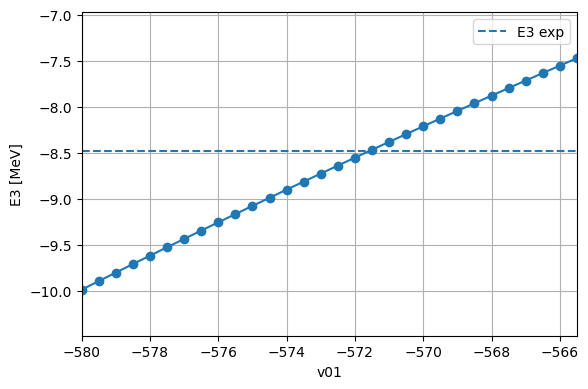

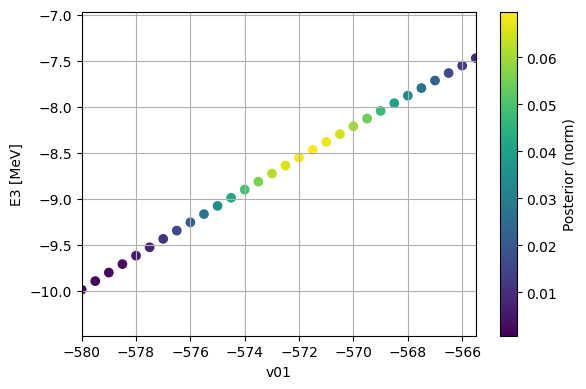

In [57]:
import numpy as np
import matplotlib.pyplot as plt

xs  = np.array([r['x'] for r in rows], float)
E3s = np.array([r['E3'] for r in rows], float)
post= np.array([r.get('post_norm', 0.0) for r in rows], float)

mask = np.isfinite(E3s)
print(f"Punti validi: {int(mask.sum())}/{len(rows)}")

if mask.any():
    y_min, y_max = float(np.nanmin(E3s[mask])), float(np.nanmax(E3s[mask]))
    pad = max(0.5, 0.05*max(1.0, abs(y_max - y_min)))
    y_lo, y_hi = y_min - pad, y_max + pad

    fig, ax = plt.subplots(figsize=(6,4))
    (ax.plot if mask.sum()>=3 else ax.scatter)(xs[mask], E3s[mask], marker='o')
    E3_EXP = -8.482
    if y_lo <= E3_EXP <= y_hi:
        ax.axhline(E3_EXP, ls='--', label='E3 exp'); ax.legend()
    ax.set_xlim(float(xs[mask].min()), float(xs[mask].max()))
    ax.set_ylim(y_lo, y_hi)
    ax.set_xlabel('v01'); ax.set_ylabel('E3 [MeV]'); ax.grid(True); plt.tight_layout()
    plt.show()

    if np.isfinite(post[mask]).any():
        fig, ax = plt.subplots(figsize=(6,4))
        sc = ax.scatter(xs[mask], E3s[mask], c=post[mask])
        cb = plt.colorbar(sc, ax=ax); cb.set_label('Posterior (norm)')
        ax.set_xlim(float(xs[mask].min()), float(xs[mask].max()))
        ax.set_ylim(y_lo, y_hi)
        ax.set_xlabel('v01'); ax.set_ylabel('E3 [MeV]'); ax.grid(True); plt.tight_layout()
        plt.show()
else:
    print("Nessun E3 finito da plottare.")



### Mini scansione attorno ad un punto

Migliore soluzione trovata:


,v01,v02,a1,a2,E3,logpost
0,-572,1422,1.55,3.11,-8.469958,-0.226083



Risultati completi:


,v01,v02,a1,a2,E3,logpost
0,-574,1422,1.55,3.11,-8.815263,-0.447921
1,-574,1425,1.55,3.11,-8.689278,-0.311721
2,-574,1428,1.55,3.11,-8.564707,-0.239474
3,-573,1422,1.55,3.11,-8.641715,-0.276811
4,-573,1425,1.55,3.11,-8.517282,-0.228283
5,-573,1428,1.55,3.11,-8.394254,-0.241192
6,-572,1422,1.55,3.11,-8.469958,-0.226083
7,-572,1425,1.55,3.11,-8.347070,-0.262205
8,-572,1428,1.55,3.11,-8.225574,-0.357301
9,-571,1422,1.55,3.11,-8.300000,-0.292041


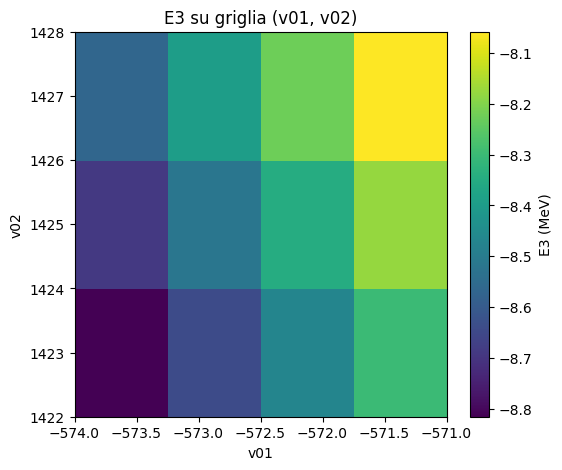

In [ ]:
from runner import TrimodRunner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

tr = TrimodRunner(exe="./run", workdir="./WORK")

#Definizione del punto intorno al quale si vuole scansionare
v01_list = [-574, -573, -572, -571]
v02_list = [1422, 1425, 1428]
a1, a2   = 1.55, 3.11

#Scansione 2D (v01, v02) tenendo fissi a1,a2
rows = []
for v01 in v01_list:
    for v02 in v02_list:
        theta = (v01, v02, a1, a2)
        r     = eval_posterior(theta, tr=tr)  
        rows.append({
            'v01': v01,
            'v02': v02,
            'a1': a1,
            'a2': a2,
            'E3': r['E3'],
            'logpost': r['post'],
        })

df = pd.DataFrame(rows)

#Ordina per log posterior (massimo = migliore)
df_best = df.sort_values(by='logpost', ascending=False).reset_index(drop=True)

print("Migliore soluzione trovata:")
display(df_best.head(1))

print("\nRisultati completi:")
display(df)

#Plot heatmap di E3 rispetto a v01 e v02) 
pivot = df.pivot(index='v02', columns='v01', values='E3')
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(pivot.values, origin='lower', 
               extent=(min(v01_list), max(v01_list), min(v02_list), max(v02_list)),
               aspect='auto')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("E3 (MeV)")
ax.set_xlabel("v01")
ax.set_ylabel("v02")
ax.set_title("E3 su griglia (v01, v02)")
plt.show()